In [1]:
import sys
print("python version: ", sys.version)

import pandas as pd
print("pandas version: ", pd.__version__)

import numpy as np
print('numpy version: ', np.__version__)

import scipy as sp
print('scipy version: ', sp.__version__)

import sklearn as skl
print('sklearn version: ', skl.__version__)

import matplotlib.pyplot as plt

import seaborn as sns

import keras as ks
print('keras version: ', ks.__version__)
print('keras backend: ', ks.backend.backend())

import tensorflow as tf
print('tensorflow version: ', tf.__version__)

import theano as th
print('theano version: ', th.__version__)

import warnings
warnings.filterwarnings('ignore')


from keras import backend as K
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.metrics import roc_curve, auc, f1_score, accuracy_score, precision_recall_curve

import os
import random

('python version: ', '2.7.15 |Anaconda, Inc.| (default, Dec 14 2018, 19:04:19) \n[GCC 7.3.0]')
('pandas version: ', u'0.23.4')
('numpy version: ', '1.15.4')
('scipy version: ', '1.1.0')
('sklearn version: ', '0.19.2')


Using TensorFlow backend.


('keras version: ', '2.1.6')
('keras backend: ', u'tensorflow')
('tensorflow version: ', '1.10.0')
('theano version: ', '0.8.2')


In [2]:
def set_keras_backend(backend):
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        reload(K)
        assert K.backend() == backend

set_keras_backend("tensorflow")

In [3]:
excel_file = r'geriomop-data-from-egems-paper-UPDATED-COL-FIX-ATC_2-and-behavior-change-022819.tsv'
df = pd.DataFrame(pd.read_csv(excel_file, sep='\t'))
print(df.shape)

(7584, 208)


In [4]:
# Get atc codes
atc_list = []
for i in range(1, 6):
    atc_list.append(df.groupby('atc_%d' % i)['min_effective_dose_%d' % i].first())
atc_codes = pd.concat(atc_list)
atc_codes = atc_codes[~atc_codes.index.duplicated()].index.tolist()

# Fill missing min_effective_dose
atc_dic = [('N03AE01', 0.5), ('N05AB04', 15), ('N05AX13', 3), ('N05CD04', 1), ('N06AX21', 60), ('N06AX24', 20), \
           ('N06AX23', 50)]
for code, dose in atc_dic:
    for i in range(1, 6):
        df.loc[df['atc_%d' % i] == code, 'psych_sdd_%d' % i] = \
            df.loc[df['atc_%d' % i] == code, 'Psychotropic-%d-average-daily-dose' % i] / dose

# Set sdd=0 to NA
for i in range(1, 6):
    df.loc[df['psych_sdd_%d' % i] == 0, 'psych_sdd_%d' % i] = np.nan

# Missing value means not relevant
### One Hot Encoding (All zero stands for NA)
* "Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days" (Y/N/U/NA)
* "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", "mds-delirium-scale", "recent-start-other-fall-risk-rx" (Y/N/NA)
* "mds-pressure-ulcer-stage-X", (X=1, 2, 3, 4) (Y/NA)

### Label Encoding & Sin, Cos Transform (NA: (0, 0))
* "mds-cognitive-scale": 
  - 'Independent': 0, 
  - 'Modified Independence': 1, 
  - 'Moderately Impaired': 2, 
  - 'Severely Impaired': 3
* "mds-pain-freq-last-five-days": 
  - 'Continuous': 4, 
  - 'Frequent': 3, 
  - 'Occasional': 2, 
  - 'Rare': 1, 
  - 'Unable to respond': 0,
* "mds-pain-intensity": 
  - 'None': 0, 
  - 'Mild': 1, 
  - 'Moderate': 2, 
  - 'Severe': 3, 
  - 'Very severe, horrible': 4
* "Psychotropic-X": Number
* (Added) "Psychotropic-X-Period": Number


# Drop features

* ~~"Unnamed: 51"~~, 
* ~~"pk-interaction", "pk-interaction-type"~~ 
* ~~"object-drug-1", "object-drug-1-dose", "object-drug-1-effective-dose-increase", "object-drug-1-effective-dose", "interaction-1-stop-date"~~, 
* ~~"object-drug-2", "object-drug-2-dose", "object-drug-2-effective-dose-increase", "object-drug-2-effective-dose", "interaction-2-stop-date"~~
* "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"
* "Blank-1", "Deleted-X" (X from 1 to 12), "Psychotropic-X-average-daily-dose", "Psychotropic-X-Start/End-date"
* "Entry-discharge-type"

# Encode features (originally) with no missing values

### Date-related Transform

* episodePeriod = episode-end-date - episode-start-date
* stayPeriod = stay-end-date - stay-start-date

### Drop Date-related Features

* "episode-start-date", "episode-end-date", "stay-start-date", "stay-end-date", "predictor-date", "projected-date"

### Binary Encoding (Y/N)

* "cms-long-stay", "mds-stay-trans-short-to-long",
* "mds-antianxiety-medication", "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
* "mds-anticoagulant-medication", "mds-diuretic-medication", "mds-hypnotic-medication",
* "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", "mds-dehydrated", "mds-depression", "mds-fever",
* "mds-impaired-mobility", "mds-impaired-transfer", "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions",
* "mds-vomiting", "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", "mds-impaired-locomot-other",
* "ws-antibiotic-anticoag-coexposure",
* "ws-psychotropic-with-not-ordered-weight-loss", "ws-diuretic-adl"

### One Hot Encoding

* "race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure", 

### Drop Feature
* "PPS-assessment", "Federal-assessment"

### Mapping

* mds-pain-non-verbal {'None/Mild':0,'Moderate/Severe':1}

# Features need imputation
### One Hot Encoding

1. Binary categories (Yes/No/NA)
   * "pneumonia", "uti", "mdro", "anemia", "septicemia", "constipation", 
   * "wound", "hyponatremia", "hyperkalemia", "embolisms", 
   * "alzheimers", "anxiety", "depression", "non-alz-dimentia", 
   * "bipolar", "parkinsons", "psychosis", "schizophrenia", "seizure", "aphasia", "emphysema", 
   * "arthritis", "ashd", "bph", "cancer", "cerebralpalsy", "stroke", "cirrhosis", "comatose", 
   * "diabetes", "dysrhythmias", "gerd", "heart-failure", "hemiplegia/hemiparesis", "hepatitis", 
   * "huntingtons", "hyperlipidemia", "hyperthyroidism", "hypothyroidism", "hypertension", 
   * "hypotension", "multiple-sclerosis", "neurogenic-bladder", "obstructive-uropathy", 
   * "osteoporosis", "paraplegia", "ptsd", "pvd", "quadriplegia", "thyroid-disorder", 
   * "tourettes", "transient-ischemic-attack", "traumatic-brain-injury", "tuberculosis", "renal-failure", 

   * "mds-delirium-scale", "mds-pain-medication", "mds-received-pain-tx-non-pharm ", "mds-received-prn-pain-medication",
   * "mds-conduct-staff-assessment-mental-status", "mds-pressure-ulcer-prsnt", "conduct_bims", "acute_mental_change",
   * "conduct_pain_assmnt", "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", 
   * "limb_prosthesis_past_7_days", "no_listed_mobility_device", 


2. Other categories

   * "marital-status": 
     - "Never Married", "Married", "Widowed", "Separated", "Divorced"
   * "mds-entered-from": 
     - "Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", "Inpatient rehabilitation facility"
     - "Community (private home/apt., board/care, assisted living, group home)",  "Other", 
   * "mds-excess-weight-loss": 
     - "Yes - prescribed", "Yes - not prescribed", "No or unknown"
   * "balance_while_standing", "balance_while_walking", "balance_turning_around", "balance_toileting", "balance_bed_to_chair"
     - "Steady at all times", "able to stabilize without assistance", "able to stabilize with assistance", "Activity did not occur"
    
### Label Encoding
* "mds-urinary-incontinence"
  - "Always continent": 0, 
  - "Occasionally incontinent": 1,
  - "Frequently incontinent": 2,
  - "Always incontinent": 3,
  - "Catheter - not rated": (0, 0)


* "cam_inattention",
* "cam_disorganized_thought",
* "cam_altered_conc",
* "cam_motor_retardation"
  - "Behavior not present": 0,
  - "Behavior present, fluctuates": 1, 
  - "Behavior continuously present": 2, 

   
* "functlimit_rom_upper", 
* "functlimit_rom_lower"
   - "No impairment": 0, 
   - "Impairment on one side": 1, 
   - "Impairment on both sides": 2 


* "does_resident_wander"
   - "Behavior not exhibited": 0, 
   - "1 to 3 days": 1, 
   - "4 to 6 days": 2, 
   - "occurred daily": 3,

# Features from new dataset
* "atc_X" (X from 1 to 5) - one hot encoding
* "number_of_behavior_changes" - keep
* "min_effective_dose_X" - drop
* "psych_sdd_X" - sin/cos transform

In [5]:
# drop feature
def drop_features(df, f):
    df.drop(f, axis=1, inplace=True)

In [6]:
# one hot encoding
def one_hot_encoding(df, features, categories):
    for f, c in zip(features, categories):
        df[f] = df[f].astype('category', categories=c)
    return pd.get_dummies(df, columns=features, prefix=features)

In [7]:
# compute date difference
def date_diff(start, end):
    return (pd.to_datetime(end) - pd.to_datetime(start)) / np.timedelta64(1, 'D')

In [8]:
# generate date diff features
def generate_period(df, f):
    for start, end, period in f:
        df[period] = date_diff(df[start], df[end])
        df.drop([start, end], axis=1, inplace=True)

In [9]:
# label encoding
def label_encoding(df, features, dictionaries):
    for f, dic in zip(features, dictionaries):
        df[f] = df[f].map(dic)

In [10]:
# sin&cos transform
def col_transform(df, col, mmax, mmin, df_ref=None):
    if(mmax <= mmin):
        # for test set, if max&min not set, use training set value
        if(df_ref is not None): 
            mmax = df_ref[col].max()
            mmin = df_ref[col].max()
        else:
            mmax = df[col].max()
            mmin = df[col].min()
    angle = 0.25 * np.pi * (df[col] - mmin) / (mmax - mmin) + 0.125 * np.pi
    return (np.cos(angle), np.sin(angle))

def df_transform(df, f, df_ref=None):
    for col, mmax, mmin in f:
        df[col + '_x'], df[col + '_y'] = col_transform(df, col, mmax, mmin, df_ref)
        df[col + '_x'].fillna(0, inplace=True)
        df[col + '_y'].fillna(0, inplace=True)
        df.drop(col, axis=1, inplace=True)

In [11]:
# train test split
from sklearn.model_selection import GroupShuffleSplit
def train_test_split(df, target, groupby, radio, random_state):
    train_idx, test_idx = GroupShuffleSplit(train_size=radio, random_state=random_state).split(df, target, df[groupby]).next()
    return df.iloc[train_idx], df.iloc[test_idx], target.iloc[train_idx], target.iloc[test_idx]

In [12]:
# missing data describe
def missing_summary(df):
    missing_cnt = df.isna().sum()
    missing_data = pd.concat([missing_cnt, missing_cnt/df.shape[0]], axis=1, keys=['count', 'percentage'])
    return missing_data[missing_data['percentage'] != 0].sort_values(by='percentage', ascending=False)

In [13]:
# Drop features
f_drop = ["Blank-1", "ws-sudden-stop", "ws-sudden-stop-drugs", "ws-prolonged-psychotropics", "mds-toilet-prgm-atmptd"] + \
         ['Deleted-%d' % i for i in range(1, 13)] + ['Psychotropic-%d' % i for i in range(1, 6)] + \
         ['Psychotropic-%d-average-daily-dose' % i for i in range(1, 6)] + ["Entry-discharge-type"]

# Missing value means not relevant
f_one_hot = ["Mds-fall-2-6-months-to-admission", "Mds-fall-last-month-to-admission", "mds-pain-last-five-days", \
             "mds-delirium-scale", "mds-long-term-memory-ok", "mds-short-term-memory-ok", "mds-staff-assess-pain", \
             "recent-start-other-fall-risk-rx"] + ["mds-pressure-ulcer-stage-%d" % i for i in range(1, 5)]
cate_one_hot = [['Yes', 'No', 'Unable to answer']] * 3 + [['Yes', 'No']] * 9

f_period = [("Psychotropic-%d-Start-date" % i, 'Psychotropic-%d-End-date' % i, 'Psychotropic-%d-Period' % i) for i in range(1, 6)]

f_label = ['mds-cognitive-scale', 'mds-pain-freq-last-five-days', 'mds-pain-intensity']
dic_label = [{'Independent': 0, 'Modified Independence': 1, 'Moderately Impaired': 2, 'Severely Impaired': 3}, \
             {'Continuous': 4, 'Frequent': 3, 'Occasional': 2, 'Rare': 1, 'Unable to respond': 0}, \
             {'None': 0, 'Mild': 1, 'Moderate': 2, 'Severe': 3, 'Very severe, horrible': 4}]

f_transform = [('mds-cognitive-scale', 3, 0), ('mds-pain-freq-last-five-days', 4, 0), ('mds-pain-intensity', 4, 0)] + \
              [('Psychotropic-%d-Period' % i, 0, 0) for i in range(1, 6)]

In [14]:
# Encode features (originally) with no missing values
f_drop += ["predictor-date", "projected-date", "PPS-assessment", "Federal-assessment"]

f_period += [('episode-start-date', 'episode-end-date', 'episode-period'),\
             ('stay-start-date', 'stay-end-date', 'stay-period')]

f_label += ["cms-long-stay", "mds-stay-trans-short-to-long", "mds-antianxiety-medication", \
            "mds-antidepressant-medication", "mds-antipsychotic-medication", "mds-antibiotic-medication",
            "mds-anticoagulant-medication", "mds-diuretic-medication", \
            "mds-hypnotic-medication", "mds-behavioral-symptoms", "mds-behavioral-symptoms-to-others", \
            "mds-dehydrated", "mds-depression", "mds-fever", "mds-impaired-mobility", "mds-impaired-transfer", \
            "mds-internal-bleeding", "mds-malnutrition", "mds-no-problem-conditions", "mds-vomiting", \
            "mds-impaired-walk-in-room", "mds-impaired-walk-in-corridor", "mds-impaired-locomot-unit", \
            "mds-impaired-locomot-other", "ws-antibiotic-anticoag-coexposure", \
            "ws-psychotropic-with-not-ordered-weight-loss", \
            "ws-diuretic-adl", "ws-tramadol-antidepressant-coexposure"] + ["mds-pain-non-verbal"]
dic_label += [{'Yes': 1, 'No': 0}] * 28 + [{'None/Mild':0,'Moderate/Severe':1}]

f_one_hot += ["race", "facility", "gender", "mds-bims-summary-ranking", "ws-meclizine-psych-coexposure"]
cate_one_hot += [['White', 'Black', 'Other'], \
                 ['Sugar Creek', 'Heritage Place', 'Canterbury Place', 'Senaca Place', 'Cranberry Place'], \
                 ['Female', 'Male'], ['Intact or Moderately Intact', 'Moderate Impairment'], \
                 ['No', 'meclAndPsychStartSameR', 'meclPrecedesPsychR', 'psychPrecedesMeclR', 'meclAndPsychOlderStart']]

In [15]:
# Features need imputation
f_one_hot += ["pneumonia", "uti", "mdro", "anemia", "septicemia", "constipation", "wound", "hyponatremia", \
              "hyperkalemia", "embolisms", "alzheimers", "anxiety", "depression", "non-alz-dimentia", "bipolar", \
              "parkinsons", "psychosis", "schizophrenia", "seizure", "aphasia", "emphysema", "arthritis", "ashd", \
              "bph", "cancer", "cerebralpalsy", "stroke", "cirrhosis", "comatose", "diabetes", "dysrhythmias", "gerd", \
              "heart-failure", "hemiplegia/hemiparesis", "hepatitis", "huntingtons", "hyperlipidemia", "hyperthyroidism", \
              "hypothyroidism", "hypertension", "hypotension", "multiple-sclerosis", "neurogenic-bladder", \
              "obstructive-uropathy", "osteoporosis", "paraplegia", "ptsd", "pvd", "quadriplegia", "thyroid-disorder",\
              "tourettes", "transient-ischemic-attack", "traumatic-brain-injury", "tuberculosis", "renal-failure",\
              "mds-delirium-scale", "mds-pain-medication", "mds-received-pain-tx-non-pharm", \
              "mds-received-prn-pain-medication", "mds-conduct-staff-assessment-mental-status", \
              "mds-pressure-ulcer-prsnt", "conduct_bims", "acute_mental_change", "conduct_pain_assmnt", \
              "cane_or_crutch_past_7_days", "walker_past_7_days", "wheelchair_past_7_days", \
              "limb_prosthesis_past_7_days", "no_listed_mobility_device"] + \
              ["balance_while_standing", "balance_while_walking", "balance_turning_around", \
               "balance_toileting", "balance_bed_to_chair"] + \
              ["marital-status", "mds-entered-from", "mds-excess-weight-loss"]
cate_one_hot += [['Yes', 'No']] * 69 + \
                [["Steady at all times", "able to stabilize without assistance", \
                  "able to stabilize with assistance", "Activity did not occur"]] * 5 + \
                [["Never Married", "Married", "Widowed", "Separated", "Divorced"], \
                 ["Acute Hospital", "Psychiatric Hospital", "Another nursing home or swing bed", "Hospice", \
                  "Inpatient rehabilitation facility",
                  "Community (private home/apt., board/care, assisted living, group home)", "Other"],
                 ["Yes - prescribed", "Yes - not prescribed", "No or unknown"]]

f_label += ["mds-urinary-incontinence", "functlimit_rom_upper", "functlimit_rom_lower", "does_resident_wander"] + \
           ["cam_inattention", "cam_disorganized_thought", "cam_altered_conc", "cam_motor_retardation"]
dic_label += [{"Always continent": 0, "Occasionally incontinent": 1, "Frequently incontinent": 2,\
               "Always incontinent": 3, "Catheter - not rated": np.nan}] + \
             [{"No impairment": 0, "Impairment on one side": 1, "Impairment on both sides": 2}] * 2 + \
             [{"Behavior not exhibited": 0, "1 to 3 days": 1, "4 to 6 days": 2, "occurred daily": 3}] + \
             [{"Behavior not present": 0, "Behavior present, fluctuates": 1, "Behavior continuously present": 2}] * 4

f_transform += [("mds-urinary-incontinence", 3, 0), ("cam_inattention", 2, 0), ("cam_disorganized_thought", 2, 0), \
                ("cam_altered_conc", 2, 0), ("cam_motor_retardation", 2, 0), ("functlimit_rom_upper", 2, 0), \
                ("functlimit_rom_lower", 2, 0), ("does_resident_wander", 3, 0)]

In [16]:
# Features from new dataset
f_drop += ["min_effective_dose_%d" % i for i in range(1, 6)]

f_one_hot += ["atc_%d" % i for i in range(1, 6)]
cate_one_hot += [atc_codes] * 5

f_transform += [('psych_sdd_%d' % i, 0, 0) for i in range(1, 6)]

In [17]:
# generate target
target = df['outcome-Mds-fall-since-prior-assessment'].map({'None': 0, 'Yes': 1})
dff = df.drop(['outcome-mds-fall-no-injury', 'outcome-mds-fall-minor-injury', 'outcome-mds-fall-major-injury', \
               'outcome-Mds-fall-since-prior-assessment', 'outcome-riskmaster-fall-incident'], axis=1)

In [18]:
X_train, X_test, y_train, y_test = train_test_split(dff, target, 'patient-id', 0.7, 0)
print 'Total number of patients: %d' % len(df.groupby('patient-id'))
print 'Number of patients in training set: %d' % len(X_train.groupby('patient-id'))

Total number of patients: 3133
Number of patients in training set: 2193


In [19]:
%%time
generate_period(X_train, f_period)
label_encoding(X_train, f_label, dic_label)
X_train_original = X_train.copy() # store value range
df_transform(X_train, f_transform)
X_train = one_hot_encoding(X_train, f_one_hot, cate_one_hot)
drop_features(X_train, f_drop)

CPU times: user 31.5 s, sys: 668 ms, total: 32.2 s
Wall time: 19.1 s


In [20]:
X_train_use = X_train.copy()

In [21]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([], dtype='object')


In [22]:
missing_summary(X_train_use)

,count,percentage


In [23]:
%%time
generate_period(X_test, f_period)
label_encoding(X_test, f_label, dic_label)
df_transform(X_test, f_transform, X_train_original)
X_test = one_hot_encoding(X_test, f_one_hot, cate_one_hot)
drop_features(X_test, f_drop)

CPU times: user 17.2 s, sys: 12 ms, total: 17.2 s
Wall time: 17.1 s


In [24]:
X_test_use = X_test.copy()

In [25]:
print(X_train.dtypes[X_train.dtypes == 'object'].index)

Index([], dtype='object')


In [26]:
missing_summary(X_train_use)

,count,percentage


In [27]:
X_train_use.shape

(5311, 524)

In [28]:
X_test_use.shape

(1512, 524)

### RNN

In [29]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout
from numpy.random import seed
from tensorflow import set_random_seed

In [30]:
def scaler_transform(X_train_use, X_test_use):    
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(X_train_use.drop('patient-id', axis=1))
    X_train_transformed = pd.DataFrame(scaler.transform(X_train_use.drop('patient-id', axis=1)), \
                                       columns=X_train_use.columns[1:], index=X_train_use.index)                                   
    X_train_transformed['patient-id'] = X_train_use['patient-id']
    X_test_transformed = pd.DataFrame(scaler.transform(X_test_use.drop('patient-id', axis=1)), \
                                       columns=X_test_use.columns[1:], index=X_test_use.index) 
    X_test_transformed['patient-id'] = X_test_use['patient-id']
    return X_train_transformed, X_test_transformed

In [31]:
def generate_nested_list(X, Y):
    X = X.copy()
    Y = Y.copy()
    x_list, y_list = [], [] 
    x1, x2 = [], []
    pids = X['patient-id'].unique()
    for pid in pids:
        df = Y[X[X['patient-id']==pid].index]
        if(df.shape[0] == 1):
            x1.append(pd.Series([0]))
            x2.append(pd.Series([0]))
        else:
            # input 1=(1, 0), 0=(0, 1), NA=(0, 0)
            x1.append(pd.Series([0]))
            x1.append(df[:-1])
            x2.append(pd.Series([0]))
            x2.append(df[:-1].map({0: 1, 1: 0}))
    X['input_outcome_x'] = pd.Series(pd.concat(x1, ignore_index=True).tolist(), index=X.index)
    X['input_outcome_y'] = pd.Series(pd.concat(x2, ignore_index=True).tolist(), index=X.index)
    for pid in pids:
        df = X[X['patient-id']==pid]
        y_list.append(Y[df.index].values)
        x_list.append([record for record in df.drop('patient-id', axis=1).values])
    return x_list, y_list

In [32]:
def mygenerator(x_list, y_list=None):
    if(y_list is not None):
        while True:
            for x, y in zip(x_list, y_list):
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])), y
    else:
        while True:
            for x in x_list:
                yield np.array(x).reshape((len(x), 1, x[0].shape[0])) 

In [33]:
def fit_model(model, epoch, X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    if(verbose == 0):
        model.fit_generator(mygenerator(X_train, y_train), steps_per_epoch=len(X_train), epochs=epoch, verbose=0)
    else:
        history = model.fit_generator(mygenerator(X_train, y_train), steps_per_epoch=len(X_train), \
                                      validation_data=mygenerator(X_valid, y_valid), validation_steps=len(X_valid), \
                                      epochs=epoch, verbose=verbose)
        plot_history(history)
    return history

In [34]:
def plot_roc_curve(fpr, tpr):
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % auc(fpr, tpr))
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

In [35]:
def plot_history(history):
    plt.figure()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.show()

In [36]:
from sklearn.model_selection import GroupKFold
def kfold_validation(unit, ratio, epoch, X, y, groupby, k=5, verbose=0):
    auroc_list = []
    for train_idx, valid_idx in GroupKFold(n_splits=5).split(X, y, X[groupby]):
        X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y.iloc[train_idx], y.iloc[valid_idx]
        X_train, y_train = generate_nested_list(X_train, y_train)
        X_valid, y_valid = generate_nested_list(X_valid, y_valid)
        seed(1)
        set_random_seed(2)
        model = build_model(unit, ratio, 1, X_train[0][0].shape[0])
        if (verbose == 0):
            fit_model(model, epoch, X_train, y_train)
        else:
            fit_model(model, epoch, X_train, y_train, X_valid, y_valid, verbose)
        y_predict = model.predict_generator(mygenerator(X_valid), steps=len(X_valid))
        y_predict = np.concatenate(y_predict)
        y_true = np.concatenate(y_valid)
        auroc_list.append(auroc(y_predict, y_true))
    return auroc_list 

In [37]:
def auroc(y_predict, y_true, plot=False):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1)    
    if(plot):
        plot_roc_curve(fpr, tpr)
    return auc(fpr, tpr)

In [38]:
def find_best_f1(y_predict, y_true):
    fpr, tpr, thresholds = roc_curve(y_true, y_predict, pos_label=1) 
    max_f1, th = 0, 0
    for threshold in thresholds:
        f1 = f1_score(y_true, y_predict > threshold)
        if(f1 > max_f1):
            max_f1 = f1
            th = threshold
    return max_f1, th

In [39]:
def other_metrics(y_predict, y_true, threshold):
    y_threshold = y_predict > threshold
    tn, fp, fn, tp = confusion_matrix(y_true, y_threshold).ravel()
    return precision_score(y_true, y_threshold), recall_score(y_true, y_threshold),\
            accuracy_score(y_true, y_threshold), float(tn) / (tn + fp)

In [40]:
X_train_transformed, X_test_transformed = scaler_transform(X_train_use, X_test_use)

In [41]:
# %%time
X_train_list, y_train_list = generate_nested_list(X_train_transformed, y_train)
X_test_list, y_test_list = generate_nested_list(X_test_transformed, y_test)

In [70]:
from keras import regularizers
def build_model(cell_size, dropout_ratio, n_timesteps, n_dimensions):
    model = Sequential()
    model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=0.1, dropout=dropout_ratio))
#     model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=0.4, recurrent_regularizer=regularizers.l2(dropout_ratio)))
#     model.add(LSTM(cell_size, input_shape=(n_timesteps, n_dimensions)))
#     model.add(GRU(cell_size, input_shape=(n_timesteps, n_dimensions), recurrent_dropout=dropout_ratio))
#     model.add(Dropout(dropout_ratio))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['binary_accuracy'])
    return model

Epoch 1/40
2193/2193 [==============================] - 14s 6ms/step - loss: 0.3721 - binary_accuracy: 0.8707 - val_loss: 0.4611 - val_binary_accuracy: 0.8128
Epoch 2/40
2193/2193 [==============================] - 8s 4ms/step - loss: 0.3538 - binary_accuracy: 0.8712 - val_loss: 0.4580 - val_binary_accuracy: 0.8128
Epoch 3/40
2193/2193 [==============================] - 8s 4ms/step - loss: 0.3543 - binary_accuracy: 0.8716 - val_loss: 0.4554 - val_binary_accuracy: 0.8128
Epoch 4/40
2193/2193 [==============================] - 8s 4ms/step - loss: 0.3468 - binary_accuracy: 0.8717 - val_loss: 0.4524 - val_binary_accuracy: 0.8128
Epoch 5/40
2193/2193 [==============================] - 8s 4ms/step - loss: 0.3449 - binary_accuracy: 0.8712 - val_loss: 0.4522 - val_binary_accuracy: 0.8128
Epoch 6/40
2193/2193 [==============================] - 8s 4ms/step - loss: 0.3473 - binary_accuracy: 0.8710 - val_loss: 0.4501 - val_binary_accuracy: 0.8128
Epoch 7/40
2193/2193 [=============================

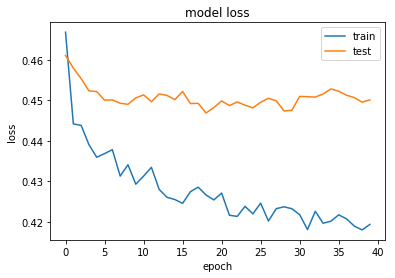

('avg auroc: ', 0.7088730244072143)
('avg precision: ', 0.3688118811881188)
('avg recall: ', 0.5265017667844523)
('avg accuracy: ', 0.7427248677248677)
('avg specificity: ', 0.7925142392188771)
('avg f1: ', 0.43377001455604075)
('auroc: ', [0.7088730244072143])
('precision: ', [0.3688118811881188])
('recall: ', [0.5265017667844523])
('accuracy: ', [0.7427248677248677])
('specificity: ', [0.7925142392188771])
('f1: ', [0.43377001455604075])
CPU times: user 11min 57s, sys: 1min 29s, total: 13min 26s
Wall time: 5min 33s


In [55]:
%%time
seed(1)
set_random_seed(2)
auroc_list = []
precision_list = []
recall_list = []
accuracy_list = []
specificity_list = []
f1_list = []
for i in range(0,1):
    model = build_model(32, 0.1, 1, X_train_list[0][0].shape[0])
    history = fit_model(model, 40, X_train_list, y_train_list, X_test_list, y_test_list, verbose=1)
    y_predict = model.predict_generator(mygenerator(X_test_list), steps=len(X_test_list))
    y_predict = np.concatenate(y_predict)
    y_true = np.concatenate(y_test_list)
    auroc_list.append(auroc(y_predict, y_true))
    f1, th = find_best_f1(y_predict, y_true)
    f1_list.append(f1)
    precision, recall, accuracy, specificity = other_metrics(y_predict, y_true, th)
    precision_list.append(precision)
    recall_list.append(recall)
    accuracy_list.append(accuracy)
    specificity_list.append(specificity)
print('avg auroc: ', np.mean(auroc_list))
print('avg precision: ', np.mean(precision_list))
print('avg recall: ', np.mean(recall_list))
print('avg accuracy: ', np.mean(accuracy_list))
print('avg specificity: ', np.mean(specificity_list))
print('avg f1: ', np.mean(f1_list));
print('auroc: ', auroc_list)
print('precision: ', precision_list)
print('recall: ', recall_list)
print('accuracy: ', accuracy_list)
print('specificity: ', specificity_list)
print('f1: ', f1_list);

unit: 4 	epoch: 100	auroc_mean: 0.711403	auroc_std: 0.018083
unit: 8 	epoch: 100	auroc_mean: 0.704040	auroc_std: 0.014856  ratio=0.15
unit: 8 	epoch: 100	auroc_mean: 0.713268	auroc_std: 0.014817  ratio=0.4
unit: 8 	epoch: 100	auroc_mean: 0.712970	auroc_std: 0.016040  ratio=0.5
unit: 8 	epoch: 100	auroc_mean: 0.711125	auroc_std: 0.018725  ratio=0.7
unit: 8 	epoch: 100	auroc_mean: 0.705248	auroc_std: 0.019450 (dropout=0.8)
unit: 16	epoch: 100	auroc_mean: 0.711807	auroc_std: 0.014130
unit: 20	epoch: 100	auroc_mean: 0.711497	auroc_std: 0.015249
unit: 32	epoch: 100	auroc_mean: 0.711760	auroc_std: 0.014548
unit: 32	epoch: 100	auroc_mean: 0.707636	auroc_std: 0.020051 (dropout=0.8)

unit: 20	epoch: 35	auroc_mean: 0.712193	auroc_std: 0.016110
unit: 32	epoch: 35	auroc_mean: 0.714166	auroc_std: 0.01698

unit: 20	epoch: 35	auroc_mean: 0.712193	auroc_std: 0.016110
unit: 20	epoch: 100	auroc_mean: 0.711497	auroc_std: 0.015249

unit: 32	epoch: 100	auroc_mean: 0.711760	auroc_std: 0.014548
unit: 32	epoch: 80	auroc_mean: 0.712121	auroc_std: 0.014548
unit: 32	epoch: 50	auroc_mean: 0.713602	auroc_std: 0.015607
unit: 32	epoch: 45	auroc_mean: 0.713859	auroc_std: 0.016112
unit: 32	epoch: 40	auroc_mean: 0.714916	auroc_std: 0.016894
unit: 32	epoch: 35	auroc_mean: 0.714166	auroc_std: 0.016980
unit: 32	epoch: 30	auroc_mean: 0.713925	auroc_std: 0.017746
unit: 32	epoch: 20	auroc_mean: 0.713114	auroc_std: 0.018183
unit: 32	epoch: 15	auroc_mean: 0.711412	auroc_std: 0.018786

unit: 4 	epoch: 50	auroc_mean: 0.709857	auroc_std: 0.018303
unit: 4 	epoch: 100	auroc_mean: 0.711403	auroc_std: 0.018083

unit: 8 	epoch: 50	auroc_mean: 0.712523	auroc_std: 0.017950
unit: 8 	epoch: 90	auroc_mean: 0.712820	auroc_std: 0.016247
unit: 8 	epoch: 100	auroc_mean: 0.712970	auroc_std: 0.016040

Epoch 1/90
1754/1754 [==============================] - 21s 12ms/step - loss: 0.3808 - binary_accuracy: 0.8706 - val_loss: 0.4587 - val_binary_accuracy: 0.8156
Epoch 2/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3660 - binary_accuracy: 0.8705 - val_loss: 0.4472 - val_binary_accuracy: 0.8156
Epoch 3/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3612 - binary_accuracy: 0.8707 - val_loss: 0.4469 - val_binary_accuracy: 0.8156
Epoch 4/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3580 - binary_accuracy: 0.8707 - val_loss: 0.4445 - val_binary_accuracy: 0.8147
Epoch 5/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3552 - binary_accuracy: 0.8702 - val_loss: 0.4426 - val_binary_accuracy: 0.8137
Epoch 6/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3513 - binary_accuracy: 0.8716 - val_loss: 0.4421 - val_binary_accuracy: 0.8137
Epoch 7/90
1754/1754 [============================

1754/1754 [==============================] - 7s 4ms/step - loss: 0.3308 - binary_accuracy: 0.8739 - val_loss: 0.4380 - val_binary_accuracy: 0.8175
Epoch 53/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3335 - binary_accuracy: 0.8751 - val_loss: 0.4382 - val_binary_accuracy: 0.8156
Epoch 54/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3307 - binary_accuracy: 0.8754 - val_loss: 0.4377 - val_binary_accuracy: 0.8147
Epoch 55/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3298 - binary_accuracy: 0.8724 - val_loss: 0.4387 - val_binary_accuracy: 0.8166
Epoch 56/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3326 - binary_accuracy: 0.8734 - val_loss: 0.4388 - val_binary_accuracy: 0.8166
Epoch 57/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3316 - binary_accuracy: 0.8753 - val_loss: 0.4377 - val_binary_accuracy: 0.8147
Epoch 58/90
1754/1754 [==============================] - 7

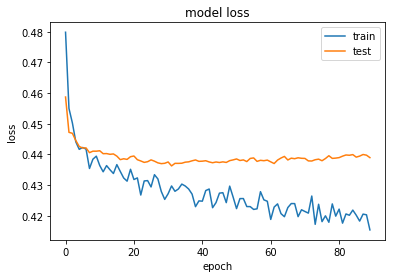

Epoch 1/90
1755/1755 [==============================] - 21s 12ms/step - loss: 0.3775 - binary_accuracy: 0.8705 - val_loss: 0.4594 - val_binary_accuracy: 0.8164
Epoch 2/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3623 - binary_accuracy: 0.8707 - val_loss: 0.4524 - val_binary_accuracy: 0.8164
Epoch 3/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3572 - binary_accuracy: 0.8707 - val_loss: 0.4505 - val_binary_accuracy: 0.8164
Epoch 4/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3582 - binary_accuracy: 0.8707 - val_loss: 0.4490 - val_binary_accuracy: 0.8164
Epoch 5/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3544 - binary_accuracy: 0.8708 - val_loss: 0.4496 - val_binary_accuracy: 0.8164
Epoch 6/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3554 - binary_accuracy: 0.8706 - val_loss: 0.4486 - val_binary_accuracy: 0.8164
Epoch 7/90
1755/1755 [============================

1755/1755 [==============================] - 7s 4ms/step - loss: 0.3315 - binary_accuracy: 0.8768 - val_loss: 0.4451 - val_binary_accuracy: 0.8277
Epoch 53/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3332 - binary_accuracy: 0.8744 - val_loss: 0.4450 - val_binary_accuracy: 0.8277
Epoch 54/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3311 - binary_accuracy: 0.8747 - val_loss: 0.4451 - val_binary_accuracy: 0.8277
Epoch 55/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3299 - binary_accuracy: 0.8744 - val_loss: 0.4453 - val_binary_accuracy: 0.8296
Epoch 56/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3284 - binary_accuracy: 0.8745 - val_loss: 0.4449 - val_binary_accuracy: 0.8305
Epoch 57/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3284 - binary_accuracy: 0.8746 - val_loss: 0.4443 - val_binary_accuracy: 0.8305
Epoch 58/90
1755/1755 [==============================] - 7

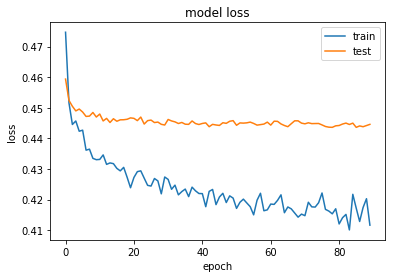

Epoch 1/90
1755/1755 [==============================] - 21s 12ms/step - loss: 0.3696 - binary_accuracy: 0.8759 - val_loss: 0.4865 - val_binary_accuracy: 0.8051
Epoch 2/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3580 - binary_accuracy: 0.8759 - val_loss: 0.4746 - val_binary_accuracy: 0.8051
Epoch 3/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3527 - binary_accuracy: 0.8759 - val_loss: 0.4675 - val_binary_accuracy: 0.8051
Epoch 4/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3452 - binary_accuracy: 0.8751 - val_loss: 0.4640 - val_binary_accuracy: 0.8051
Epoch 5/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3459 - binary_accuracy: 0.8757 - val_loss: 0.4632 - val_binary_accuracy: 0.8060
Epoch 6/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3421 - binary_accuracy: 0.8745 - val_loss: 0.4618 - val_binary_accuracy: 0.8060
Epoch 7/90
1755/1755 [============================

1755/1755 [==============================] - 7s 4ms/step - loss: 0.3207 - binary_accuracy: 0.8811 - val_loss: 0.4576 - val_binary_accuracy: 0.8032
Epoch 53/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3227 - binary_accuracy: 0.8810 - val_loss: 0.4581 - val_binary_accuracy: 0.8041
Epoch 54/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3193 - binary_accuracy: 0.8788 - val_loss: 0.4561 - val_binary_accuracy: 0.8060
Epoch 55/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3211 - binary_accuracy: 0.8779 - val_loss: 0.4567 - val_binary_accuracy: 0.8032
Epoch 56/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3263 - binary_accuracy: 0.8761 - val_loss: 0.4566 - val_binary_accuracy: 0.8023
Epoch 57/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3219 - binary_accuracy: 0.8799 - val_loss: 0.4559 - val_binary_accuracy: 0.8032
Epoch 58/90
1755/1755 [==============================] - 7

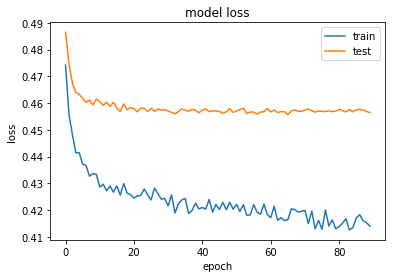

Epoch 1/90
1754/1754 [==============================] - 21s 12ms/step - loss: 0.3846 - binary_accuracy: 0.8678 - val_loss: 0.4602 - val_binary_accuracy: 0.8136
Epoch 2/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3736 - binary_accuracy: 0.8678 - val_loss: 0.4462 - val_binary_accuracy: 0.8136
Epoch 3/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3671 - binary_accuracy: 0.8678 - val_loss: 0.4414 - val_binary_accuracy: 0.8136
Epoch 4/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3652 - binary_accuracy: 0.8678 - val_loss: 0.4360 - val_binary_accuracy: 0.8136
Epoch 5/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3601 - binary_accuracy: 0.8680 - val_loss: 0.4329 - val_binary_accuracy: 0.8136
Epoch 6/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3601 - binary_accuracy: 0.8677 - val_loss: 0.4316 - val_binary_accuracy: 0.8136
Epoch 7/90
1754/1754 [============================

1754/1754 [==============================] - 8s 5ms/step - loss: 0.3394 - binary_accuracy: 0.8702 - val_loss: 0.4248 - val_binary_accuracy: 0.8154
Epoch 53/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3386 - binary_accuracy: 0.8711 - val_loss: 0.4257 - val_binary_accuracy: 0.8154
Epoch 54/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3331 - binary_accuracy: 0.8721 - val_loss: 0.4247 - val_binary_accuracy: 0.8173
Epoch 55/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3363 - binary_accuracy: 0.8714 - val_loss: 0.4258 - val_binary_accuracy: 0.8164
Epoch 56/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3372 - binary_accuracy: 0.8718 - val_loss: 0.4253 - val_binary_accuracy: 0.8164
Epoch 57/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3376 - binary_accuracy: 0.8733 - val_loss: 0.4257 - val_binary_accuracy: 0.8164
Epoch 58/90
1754/1754 [==============================] - 8

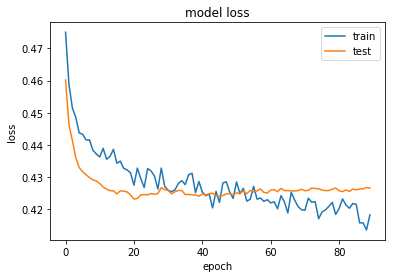

Epoch 1/90
1754/1754 [==============================] - 23s 13ms/step - loss: 0.3736 - binary_accuracy: 0.8708 - val_loss: 0.4294 - val_binary_accuracy: 0.8286
Epoch 2/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3585 - binary_accuracy: 0.8707 - val_loss: 0.4249 - val_binary_accuracy: 0.8286
Epoch 3/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3534 - binary_accuracy: 0.8709 - val_loss: 0.4230 - val_binary_accuracy: 0.8286
Epoch 4/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3516 - binary_accuracy: 0.8711 - val_loss: 0.4214 - val_binary_accuracy: 0.8286
Epoch 5/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3485 - binary_accuracy: 0.8700 - val_loss: 0.4216 - val_binary_accuracy: 0.8258
Epoch 6/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3475 - binary_accuracy: 0.8711 - val_loss: 0.4208 - val_binary_accuracy: 0.8249
Epoch 7/90
1754/1754 [============================

1754/1754 [==============================] - 7s 4ms/step - loss: 0.3249 - binary_accuracy: 0.8762 - val_loss: 0.4227 - val_binary_accuracy: 0.8305
Epoch 53/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3253 - binary_accuracy: 0.8770 - val_loss: 0.4227 - val_binary_accuracy: 0.8305
Epoch 54/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3260 - binary_accuracy: 0.8747 - val_loss: 0.4225 - val_binary_accuracy: 0.8305
Epoch 55/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3243 - binary_accuracy: 0.8741 - val_loss: 0.4221 - val_binary_accuracy: 0.8296
Epoch 56/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3313 - binary_accuracy: 0.8754 - val_loss: 0.4217 - val_binary_accuracy: 0.8296
Epoch 57/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3255 - binary_accuracy: 0.8773 - val_loss: 0.4219 - val_binary_accuracy: 0.8296
Epoch 58/90
1754/1754 [==============================] - 7

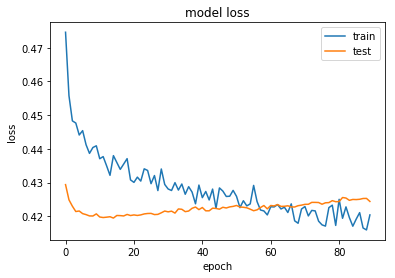

unit: 8	epoch: 90	auroc_mean: 0.712820	auroc_std: 0.016247
CPU times: user 1h 37min 5s, sys: 11min 40s, total: 1h 48min 46s
Wall time: 55min 30s


In [69]:
%%time
ratio = 0.1
result = []
pdic = [(8, [90])]
for unit, epoch_list in pdic:
    for epoch in epoch_list:
        auroc_list = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', verbose=1)
        result.append((unit, epoch, auroc_list))
        print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))

Epoch 1/90
1754/1754 [==============================] - 25s 14ms/step - loss: 0.3784 - binary_accuracy: 0.8706 - val_loss: 0.4538 - val_binary_accuracy: 0.8156
Epoch 2/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3632 - binary_accuracy: 0.8706 - val_loss: 0.4470 - val_binary_accuracy: 0.8147
Epoch 3/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3594 - binary_accuracy: 0.8708 - val_loss: 0.4457 - val_binary_accuracy: 0.8147
Epoch 4/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3527 - binary_accuracy: 0.8712 - val_loss: 0.4419 - val_binary_accuracy: 0.8090
Epoch 5/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3530 - binary_accuracy: 0.8710 - val_loss: 0.4411 - val_binary_accuracy: 0.8100
Epoch 6/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3485 - binary_accuracy: 0.8703 - val_loss: 0.4404 - val_binary_accuracy: 0.8109
Epoch 7/90
1754/1754 [============================

1754/1754 [==============================] - 7s 4ms/step - loss: 0.3219 - binary_accuracy: 0.8779 - val_loss: 0.4350 - val_binary_accuracy: 0.8166
Epoch 53/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3281 - binary_accuracy: 0.8757 - val_loss: 0.4363 - val_binary_accuracy: 0.8175
Epoch 54/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3222 - binary_accuracy: 0.8786 - val_loss: 0.4356 - val_binary_accuracy: 0.8166
Epoch 55/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3204 - binary_accuracy: 0.8790 - val_loss: 0.4367 - val_binary_accuracy: 0.8166
Epoch 56/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3241 - binary_accuracy: 0.8774 - val_loss: 0.4361 - val_binary_accuracy: 0.8175
Epoch 57/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3212 - binary_accuracy: 0.8771 - val_loss: 0.4351 - val_binary_accuracy: 0.8184
Epoch 58/90
1754/1754 [==============================] - 9

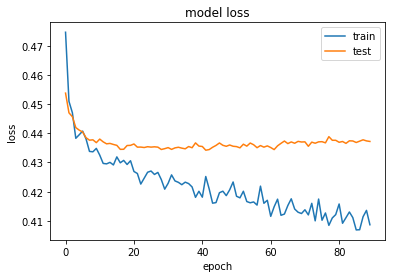

Epoch 1/90
1755/1755 [==============================] - 23s 13ms/step - loss: 0.3757 - binary_accuracy: 0.8705 - val_loss: 0.4544 - val_binary_accuracy: 0.8164
Epoch 2/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3596 - binary_accuracy: 0.8705 - val_loss: 0.4498 - val_binary_accuracy: 0.8164
Epoch 3/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3553 - binary_accuracy: 0.8707 - val_loss: 0.4489 - val_binary_accuracy: 0.8164
Epoch 4/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3524 - binary_accuracy: 0.8707 - val_loss: 0.4486 - val_binary_accuracy: 0.8173
Epoch 5/90
1755/1755 [==============================] - 6s 4ms/step - loss: 0.3513 - binary_accuracy: 0.8707 - val_loss: 0.4483 - val_binary_accuracy: 0.8211
Epoch 6/90
1755/1755 [==============================] - 6s 3ms/step - loss: 0.3506 - binary_accuracy: 0.8706 - val_loss: 0.4468 - val_binary_accuracy: 0.8220
Epoch 7/90
1755/1755 [============================

1755/1755 [==============================] - 7s 4ms/step - loss: 0.3267 - binary_accuracy: 0.8779 - val_loss: 0.4423 - val_binary_accuracy: 0.8305
Epoch 53/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3249 - binary_accuracy: 0.8754 - val_loss: 0.4433 - val_binary_accuracy: 0.8315
Epoch 54/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3221 - binary_accuracy: 0.8783 - val_loss: 0.4428 - val_binary_accuracy: 0.8315
Epoch 55/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3222 - binary_accuracy: 0.8753 - val_loss: 0.4432 - val_binary_accuracy: 0.8315
Epoch 56/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3212 - binary_accuracy: 0.8774 - val_loss: 0.4421 - val_binary_accuracy: 0.8286
Epoch 57/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3214 - binary_accuracy: 0.8763 - val_loss: 0.4424 - val_binary_accuracy: 0.8315
Epoch 58/90
1755/1755 [==============================] - 7

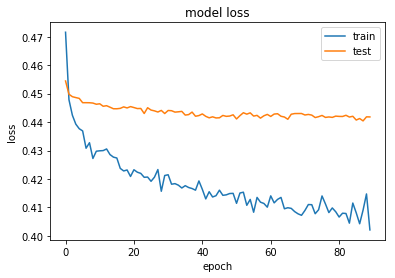

Epoch 1/90
1755/1755 [==============================] - 24s 14ms/step - loss: 0.3669 - binary_accuracy: 0.8759 - val_loss: 0.4719 - val_binary_accuracy: 0.8051
Epoch 2/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3522 - binary_accuracy: 0.8759 - val_loss: 0.4614 - val_binary_accuracy: 0.8051
Epoch 3/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3477 - binary_accuracy: 0.8755 - val_loss: 0.4592 - val_binary_accuracy: 0.8060
Epoch 4/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3403 - binary_accuracy: 0.8763 - val_loss: 0.4590 - val_binary_accuracy: 0.8032
Epoch 5/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3402 - binary_accuracy: 0.8762 - val_loss: 0.4578 - val_binary_accuracy: 0.8041
Epoch 6/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3367 - binary_accuracy: 0.8768 - val_loss: 0.4582 - val_binary_accuracy: 0.8060
Epoch 7/90
1755/1755 [============================

1755/1755 [==============================] - 7s 4ms/step - loss: 0.3138 - binary_accuracy: 0.8847 - val_loss: 0.4559 - val_binary_accuracy: 0.8060
Epoch 53/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3158 - binary_accuracy: 0.8820 - val_loss: 0.4571 - val_binary_accuracy: 0.8032
Epoch 54/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3147 - binary_accuracy: 0.8828 - val_loss: 0.4559 - val_binary_accuracy: 0.8051
Epoch 55/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3135 - binary_accuracy: 0.8822 - val_loss: 0.4560 - val_binary_accuracy: 0.8041
Epoch 56/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3173 - binary_accuracy: 0.8807 - val_loss: 0.4560 - val_binary_accuracy: 0.8051
Epoch 57/90
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3152 - binary_accuracy: 0.8835 - val_loss: 0.4555 - val_binary_accuracy: 0.8041
Epoch 58/90
1755/1755 [==============================] - 7

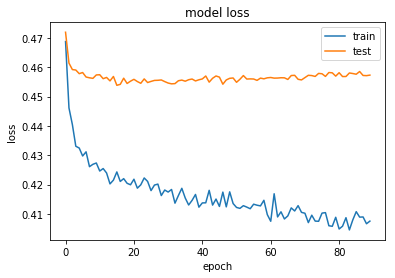

Epoch 1/90
1754/1754 [==============================] - 24s 14ms/step - loss: 0.3843 - binary_accuracy: 0.8678 - val_loss: 0.4464 - val_binary_accuracy: 0.8136
Epoch 2/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3696 - binary_accuracy: 0.8678 - val_loss: 0.4368 - val_binary_accuracy: 0.8136
Epoch 3/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3649 - binary_accuracy: 0.8679 - val_loss: 0.4316 - val_binary_accuracy: 0.8136
Epoch 4/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3618 - binary_accuracy: 0.8678 - val_loss: 0.4294 - val_binary_accuracy: 0.8136
Epoch 5/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3588 - binary_accuracy: 0.8673 - val_loss: 0.4285 - val_binary_accuracy: 0.8136
Epoch 6/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3585 - binary_accuracy: 0.8680 - val_loss: 0.4275 - val_binary_accuracy: 0.8145
Epoch 7/90
1754/1754 [============================

1754/1754 [==============================] - 8s 4ms/step - loss: 0.3306 - binary_accuracy: 0.8730 - val_loss: 0.4263 - val_binary_accuracy: 0.8154
Epoch 53/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3303 - binary_accuracy: 0.8729 - val_loss: 0.4274 - val_binary_accuracy: 0.8173
Epoch 54/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3270 - binary_accuracy: 0.8757 - val_loss: 0.4271 - val_binary_accuracy: 0.8145
Epoch 55/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3280 - binary_accuracy: 0.8744 - val_loss: 0.4272 - val_binary_accuracy: 0.8164
Epoch 56/90
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3287 - binary_accuracy: 0.8726 - val_loss: 0.4275 - val_binary_accuracy: 0.8145
Epoch 57/90
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3301 - binary_accuracy: 0.8757 - val_loss: 0.4271 - val_binary_accuracy: 0.8164
Epoch 58/90
1754/1754 [==============================] - 8

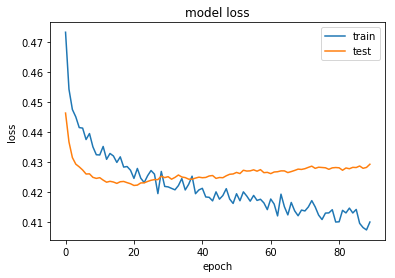

Epoch 1/90
1754/1754 [==============================] - 24s 14ms/step - loss: 0.3721 - binary_accuracy: 0.8708 - val_loss: 0.4268 - val_binary_accuracy: 0.8286
Epoch 2/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3581 - binary_accuracy: 0.8706 - val_loss: 0.4231 - val_binary_accuracy: 0.8286
Epoch 3/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3504 - binary_accuracy: 0.8714 - val_loss: 0.4218 - val_binary_accuracy: 0.8286
Epoch 4/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3493 - binary_accuracy: 0.8714 - val_loss: 0.4208 - val_binary_accuracy: 0.8305
Epoch 5/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3432 - binary_accuracy: 0.8715 - val_loss: 0.4201 - val_binary_accuracy: 0.8286
Epoch 6/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3431 - binary_accuracy: 0.8722 - val_loss: 0.4198 - val_binary_accuracy: 0.8267
Epoch 7/90
1754/1754 [============================

1754/1754 [==============================] - 7s 4ms/step - loss: 0.3215 - binary_accuracy: 0.8805 - val_loss: 0.4229 - val_binary_accuracy: 0.8315
Epoch 53/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3149 - binary_accuracy: 0.8793 - val_loss: 0.4231 - val_binary_accuracy: 0.8296
Epoch 54/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3174 - binary_accuracy: 0.8787 - val_loss: 0.4231 - val_binary_accuracy: 0.8315
Epoch 55/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3173 - binary_accuracy: 0.8766 - val_loss: 0.4228 - val_binary_accuracy: 0.8315
Epoch 56/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3222 - binary_accuracy: 0.8765 - val_loss: 0.4224 - val_binary_accuracy: 0.8324
Epoch 57/90
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3191 - binary_accuracy: 0.8794 - val_loss: 0.4229 - val_binary_accuracy: 0.8315
Epoch 58/90
1754/1754 [==============================] - 7

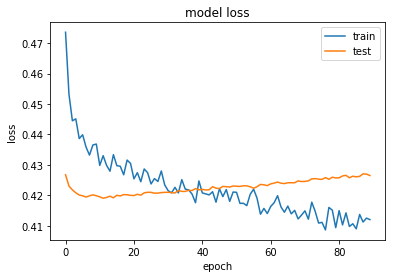

unit: 8	epoch: 90	auroc_mean: 0.713334	auroc_std: 0.014818
Epoch 1/110
1754/1754 [==============================] - 23s 13ms/step - loss: 0.3784 - binary_accuracy: 0.8706 - val_loss: 0.4537 - val_binary_accuracy: 0.8156
Epoch 2/110
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3632 - binary_accuracy: 0.8706 - val_loss: 0.4470 - val_binary_accuracy: 0.8147
Epoch 3/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3594 - binary_accuracy: 0.8708 - val_loss: 0.4457 - val_binary_accuracy: 0.8147
Epoch 4/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3527 - binary_accuracy: 0.8713 - val_loss: 0.4420 - val_binary_accuracy: 0.8090
Epoch 5/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3530 - binary_accuracy: 0.8709 - val_loss: 0.4410 - val_binary_accuracy: 0.8100
Epoch 6/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3485 - binary_accuracy: 0.8702 - val_loss: 0.4404 - val_binary_ac

Epoch 52/110
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3220 - binary_accuracy: 0.8779 - val_loss: 0.4349 - val_binary_accuracy: 0.8166
Epoch 53/110
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3281 - binary_accuracy: 0.8755 - val_loss: 0.4361 - val_binary_accuracy: 0.8175
Epoch 54/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3223 - binary_accuracy: 0.8789 - val_loss: 0.4354 - val_binary_accuracy: 0.8166
Epoch 55/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3206 - binary_accuracy: 0.8789 - val_loss: 0.4364 - val_binary_accuracy: 0.8166
Epoch 56/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3243 - binary_accuracy: 0.8775 - val_loss: 0.4358 - val_binary_accuracy: 0.8175
Epoch 57/110
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3212 - binary_accuracy: 0.8769 - val_loss: 0.4348 - val_binary_accuracy: 0.8184
Epoch 58/110
1754/1754 [================

1754/1754 [==============================] - 9s 5ms/step - loss: 0.3106 - binary_accuracy: 0.8798 - val_loss: 0.4389 - val_binary_accuracy: 0.8166
Epoch 104/110
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3114 - binary_accuracy: 0.8822 - val_loss: 0.4374 - val_binary_accuracy: 0.8194
Epoch 105/110
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3117 - binary_accuracy: 0.8791 - val_loss: 0.4378 - val_binary_accuracy: 0.8184
Epoch 106/110
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3115 - binary_accuracy: 0.8792 - val_loss: 0.4372 - val_binary_accuracy: 0.8194
Epoch 107/110
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3129 - binary_accuracy: 0.8766 - val_loss: 0.4370 - val_binary_accuracy: 0.8194
Epoch 108/110
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3064 - binary_accuracy: 0.8810 - val_loss: 0.4372 - val_binary_accuracy: 0.8203
Epoch 109/110
1754/1754 [=======================

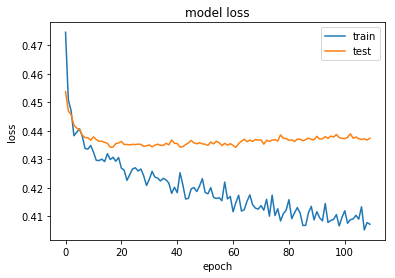

Epoch 1/110
1755/1755 [==============================] - 25s 14ms/step - loss: 0.3757 - binary_accuracy: 0.8705 - val_loss: 0.4544 - val_binary_accuracy: 0.8164
Epoch 2/110
1755/1755 [==============================] - 8s 4ms/step - loss: 0.3596 - binary_accuracy: 0.8705 - val_loss: 0.4498 - val_binary_accuracy: 0.8164
Epoch 3/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3553 - binary_accuracy: 0.8707 - val_loss: 0.4489 - val_binary_accuracy: 0.8164
Epoch 4/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3524 - binary_accuracy: 0.8707 - val_loss: 0.4486 - val_binary_accuracy: 0.8164
Epoch 5/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3513 - binary_accuracy: 0.8707 - val_loss: 0.4483 - val_binary_accuracy: 0.8211
Epoch 6/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3506 - binary_accuracy: 0.8706 - val_loss: 0.4468 - val_binary_accuracy: 0.8220
Epoch 7/110
1755/1755 [=====================

1755/1755 [==============================] - 7s 4ms/step - loss: 0.3267 - binary_accuracy: 0.8777 - val_loss: 0.4423 - val_binary_accuracy: 0.8315
Epoch 53/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3250 - binary_accuracy: 0.8754 - val_loss: 0.4433 - val_binary_accuracy: 0.8315
Epoch 54/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3221 - binary_accuracy: 0.8783 - val_loss: 0.4428 - val_binary_accuracy: 0.8315
Epoch 55/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3222 - binary_accuracy: 0.8752 - val_loss: 0.4433 - val_binary_accuracy: 0.8315
Epoch 56/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3213 - binary_accuracy: 0.8773 - val_loss: 0.4422 - val_binary_accuracy: 0.8286
Epoch 57/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3214 - binary_accuracy: 0.8765 - val_loss: 0.4425 - val_binary_accuracy: 0.8305
Epoch 58/110
1755/1755 [=============================

1755/1755 [==============================] - 5s 3ms/step - loss: 0.3132 - binary_accuracy: 0.8793 - val_loss: 0.4415 - val_binary_accuracy: 0.8315
Epoch 104/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3092 - binary_accuracy: 0.8816 - val_loss: 0.4426 - val_binary_accuracy: 0.8315
Epoch 105/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3167 - binary_accuracy: 0.8818 - val_loss: 0.4420 - val_binary_accuracy: 0.8315
Epoch 106/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3088 - binary_accuracy: 0.8802 - val_loss: 0.4424 - val_binary_accuracy: 0.8315
Epoch 107/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3149 - binary_accuracy: 0.8786 - val_loss: 0.4415 - val_binary_accuracy: 0.8315
Epoch 108/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3102 - binary_accuracy: 0.8801 - val_loss: 0.4421 - val_binary_accuracy: 0.8315
Epoch 109/110
1755/1755 [=======================

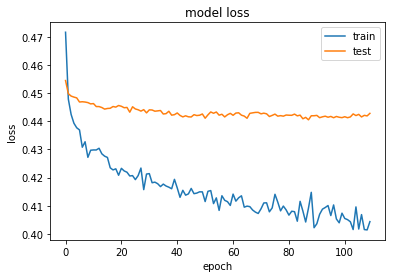

Epoch 1/110
1755/1755 [==============================] - 20s 11ms/step - loss: 0.3669 - binary_accuracy: 0.8759 - val_loss: 0.4719 - val_binary_accuracy: 0.8051
Epoch 2/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3522 - binary_accuracy: 0.8759 - val_loss: 0.4614 - val_binary_accuracy: 0.8051
Epoch 3/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3477 - binary_accuracy: 0.8755 - val_loss: 0.4592 - val_binary_accuracy: 0.8060
Epoch 4/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3403 - binary_accuracy: 0.8763 - val_loss: 0.4590 - val_binary_accuracy: 0.8032
Epoch 5/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3402 - binary_accuracy: 0.8762 - val_loss: 0.4578 - val_binary_accuracy: 0.8041
Epoch 6/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3367 - binary_accuracy: 0.8768 - val_loss: 0.4582 - val_binary_accuracy: 0.8060
Epoch 7/110
1755/1755 [=====================

1755/1755 [==============================] - 5s 3ms/step - loss: 0.3138 - binary_accuracy: 0.8847 - val_loss: 0.4559 - val_binary_accuracy: 0.8060
Epoch 53/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3158 - binary_accuracy: 0.8819 - val_loss: 0.4571 - val_binary_accuracy: 0.8032
Epoch 54/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3148 - binary_accuracy: 0.8828 - val_loss: 0.4560 - val_binary_accuracy: 0.8051
Epoch 55/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3136 - binary_accuracy: 0.8822 - val_loss: 0.4560 - val_binary_accuracy: 0.8051
Epoch 56/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3173 - binary_accuracy: 0.8807 - val_loss: 0.4560 - val_binary_accuracy: 0.8051
Epoch 57/110
1755/1755 [==============================] - 5s 3ms/step - loss: 0.3152 - binary_accuracy: 0.8835 - val_loss: 0.4555 - val_binary_accuracy: 0.8041
Epoch 58/110
1755/1755 [=============================

1755/1755 [==============================] - 9s 5ms/step - loss: 0.3024 - binary_accuracy: 0.8854 - val_loss: 0.4589 - val_binary_accuracy: 0.7994
Epoch 104/110
1755/1755 [==============================] - 8s 4ms/step - loss: 0.3005 - binary_accuracy: 0.8876 - val_loss: 0.4587 - val_binary_accuracy: 0.8013
Epoch 105/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3062 - binary_accuracy: 0.8816 - val_loss: 0.4591 - val_binary_accuracy: 0.8004
Epoch 106/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3037 - binary_accuracy: 0.8834 - val_loss: 0.4580 - val_binary_accuracy: 0.8013
Epoch 107/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3032 - binary_accuracy: 0.8828 - val_loss: 0.4587 - val_binary_accuracy: 0.8023
Epoch 108/110
1755/1755 [==============================] - 7s 4ms/step - loss: 0.3040 - binary_accuracy: 0.8836 - val_loss: 0.4596 - val_binary_accuracy: 0.8013
Epoch 109/110
1755/1755 [=======================

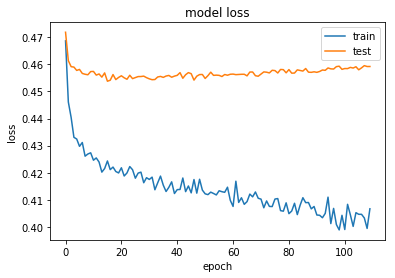

Epoch 1/110
1754/1754 [==============================] - 28s 16ms/step - loss: 0.3843 - binary_accuracy: 0.8678 - val_loss: 0.4464 - val_binary_accuracy: 0.8136
Epoch 2/110
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3696 - binary_accuracy: 0.8678 - val_loss: 0.4368 - val_binary_accuracy: 0.8136
Epoch 3/110
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3649 - binary_accuracy: 0.8679 - val_loss: 0.4316 - val_binary_accuracy: 0.8136
Epoch 4/110
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3618 - binary_accuracy: 0.8678 - val_loss: 0.4294 - val_binary_accuracy: 0.8136
Epoch 5/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3588 - binary_accuracy: 0.8674 - val_loss: 0.4285 - val_binary_accuracy: 0.8136
Epoch 6/110
1754/1754 [==============================] - 7s 4ms/step - loss: 0.3585 - binary_accuracy: 0.8680 - val_loss: 0.4275 - val_binary_accuracy: 0.8145
Epoch 7/110
1754/1754 [=====================

1754/1754 [==============================] - 8s 5ms/step - loss: 0.3307 - binary_accuracy: 0.8728 - val_loss: 0.4264 - val_binary_accuracy: 0.8154
Epoch 53/110
1754/1754 [==============================] - 8s 4ms/step - loss: 0.3303 - binary_accuracy: 0.8729 - val_loss: 0.4275 - val_binary_accuracy: 0.8173
Epoch 54/110
1754/1754 [==============================] - 9s 5ms/step - loss: 0.3271 - binary_accuracy: 0.8757 - val_loss: 0.4272 - val_binary_accuracy: 0.8145
Epoch 55/110
1754/1754 [==============================] - 10s 5ms/step - loss: 0.3280 - binary_accuracy: 0.8745 - val_loss: 0.4273 - val_binary_accuracy: 0.8164
Epoch 56/110
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3287 - binary_accuracy: 0.8728 - val_loss: 0.4277 - val_binary_accuracy: 0.8145
Epoch 57/110
1754/1754 [==============================] - 8s 5ms/step - loss: 0.3301 - binary_accuracy: 0.8757 - val_loss: 0.4272 - val_binary_accuracy: 0.8164
Epoch 58/110
1754/1754 [============================

1754/1754 [==============================] - 21s 12ms/step - loss: 0.3164 - binary_accuracy: 0.8780 - val_loss: 0.4294 - val_binary_accuracy: 0.8117
Epoch 104/110
1754/1754 [==============================] - 16s 9ms/step - loss: 0.3174 - binary_accuracy: 0.8788 - val_loss: 0.4289 - val_binary_accuracy: 0.8107
Epoch 105/110
1754/1754 [==============================] - 18s 10ms/step - loss: 0.3115 - binary_accuracy: 0.8820 - val_loss: 0.4302 - val_binary_accuracy: 0.8126
Epoch 106/110
1754/1754 [==============================] - 17s 10ms/step - loss: 0.3168 - binary_accuracy: 0.8789 - val_loss: 0.4306 - val_binary_accuracy: 0.8136
Epoch 107/110
1754/1754 [==============================] - 16s 9ms/step - loss: 0.3218 - binary_accuracy: 0.8768 - val_loss: 0.4293 - val_binary_accuracy: 0.8145
Epoch 108/110
1754/1754 [==============================] - 15s 9ms/step - loss: 0.3134 - binary_accuracy: 0.8777 - val_loss: 0.4289 - val_binary_accuracy: 0.8098
Epoch 109/110
1754/1754 [==============

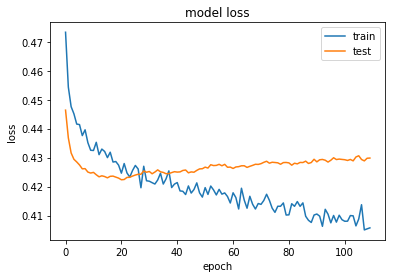

Epoch 1/110
1754/1754 [==============================] - 50s 29ms/step - loss: 0.3721 - binary_accuracy: 0.8708 - val_loss: 0.4267 - val_binary_accuracy: 0.8286
Epoch 2/110
1754/1754 [==============================] - 14s 8ms/step - loss: 0.3582 - binary_accuracy: 0.8706 - val_loss: 0.4230 - val_binary_accuracy: 0.8286
Epoch 3/110
1754/1754 [==============================] - 14s 8ms/step - loss: 0.3504 - binary_accuracy: 0.8714 - val_loss: 0.4217 - val_binary_accuracy: 0.8305
Epoch 4/110
1754/1754 [==============================] - 14s 8ms/step - loss: 0.3492 - binary_accuracy: 0.8712 - val_loss: 0.4208 - val_binary_accuracy: 0.8305
Epoch 5/110
1754/1754 [==============================] - 14s 8ms/step - loss: 0.3432 - binary_accuracy: 0.8716 - val_loss: 0.4200 - val_binary_accuracy: 0.8305
Epoch 6/110
 406/1754 [=====>........................] - ETA: 9s - loss: 0.3282 - binary_accuracy: 0.8850

In [ ]:
%%time
ratio = 0.1
result = []
pdic = [(8, [90, 110], [0.4])]
for unit, epoch_list, ratio_list in pdic:
    for epoch in epoch_list:
        for ratio in ratio_list:
            auroc_list = kfold_validation(unit, ratio, epoch, X_train_transformed, y_train, 'patient-id', verbose=1)
            result.append((unit, epoch, auroc_list))
            print("unit: %d\tepoch: %d\tauroc_mean: %f\tauroc_std: %f"  % (unit, epoch, np.mean(auroc_list), np.std(auroc_list)))